# Equatorial Thermal and Zonal Velocity Structure

This notebook contains code to plot various equatorial properties from ACCESS-OM2 simulations and compare to observations. All plots are currently focused on the Equatorial Pacific but can easily be adapted to the Atlantic or Indian, or to off-equatorial locations. 

Several sets of plots are included:

1) Longitude-depth and latitude-depth slices of temperature and zonal velocity compared to the Johnson et al. observations.

2) Longitude-depth temperature bias plots compared to WOA13.

3) Vertical profiles of temperature and zonal velocity at a specified horizontal location (140W, 0N below) compared to TAO, Johnson and WOA13 data.

4) Longitude-time Hovmoeller plots describing the seasonal cycle of SST (compared to WOA13) and zonal velocity (compared to drifter observations).

Results are compared to several observational products:

1) The WOA2013 climatological data set located in `/g/data/hh5/tmp/cosima/woa13`.

2) The Johnson et al. (2002, doi: 10.1016/s0079-6611(02)00021-6) observational data set located in `/g/data/ik11/observations/Johnson2002`.

3) TAO array mooring data located in `/g/data/ik11/observations/TAO`.

4) Laurindo et al. 2017 drifter data set for surface velocities located in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`.

1, 2 and 4 are spatially resolved data sets, while the TAO moorings are only used for the vertical profile plotting.

### Load packages, session, workers and define experiments

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import pandas as pd
import cftime
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 
import intake
catalog = intake.cat.access_nri
from dask.distributed import Client

In [2]:
client = Client("tcp://10.6.77.34:8786")
client

<Client: 'tcp://10.6.77.34:8786' processes=1 threads=12, memory=46.00 GiB>

The following code block loads the database. Note that this currently uses one of ryan's databases created using the Make_Database.ipynb notebook in order to plot the new RYF simulations in /g/data/ik11/ which are not in the default database. 

Once these runs are included in the default database the second line can be uncommented and these runs can be accessed from the default database. 

Otherwise, you can use the default database and the following cell block to plot from runs that do exist in the default database.

In [3]:
# Load session

In [4]:
# Define experiments
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degRYF',   {'model':'ACCESS-OM2 RYF', 'expt':'1deg_jra55_ryf9091_gadi', # 1deg 9091RYF run
                'n_files':-1, 'itime': None,'ftime':None}),
    ('01degRYF',  {'model':'ACCESS-OM2-01 RYF',  'expt':'01deg_jra55v13_ryf9091', # 01deg 9091RYF run
                'n_files':-4, 'itime': None,'ftime': None}),
    ('025degRYF', {'model':'ACCESS-OM2-025 RYF', 'expt':'025deg_jra55_ryf9091_gadi', # 025deg 9091RYF run
                'n_files':-1, 'itime': None,'ftime': None}),
    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55v13_iaf_spinup1_B1', # 1deg IAF run from Kiss et al. 2020
                'n_files':-12, 'itime':'1998-01-01', 'ftime':None}),
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55v13_iaf_gmredi6', # 025deg IAF run from Kiss et al. 2020
                'n_files':-34, 'itime':'1998-01-01','ftime':None})
])

In [5]:
# Define function to save figures as png and pdf files
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## Longitude-Depth and Latitude-Depth Slices compared to Johnson et al. 2002

This section includes two sets of longitude-depth and latitude-depth slices - one comparing the thermal and zonal velocity structure between ACCESS-OM2 simulations and the Johnson et al. 2002 observations, and one plotting temperature biases to the WOA13 temperature data set. These types of plots were used in the Kiss et. al GMD paper.

We start by defining the locations of our slices:

In [6]:
depths = (0,300)     # depth range for all plots [m]

EqPlons = (-217,-95) # longitude range for longitude-depth plot [degrees]
EqPlat = 0.          # latitude for longitude-depth plot [degrees]

Ltlon = -140.        # longitude for latitude-depth plot [degrees]
ObsLtlon = 220.      # longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)     # latitudes for latitude-depth plot [degrees]

### Define data-extract functions for ACCESS-OM2 data:

Define two functions that extract temperature (in degC) and zonal velocity (in cms-1) data from the ACCESS-OM2 simulations defined above. 

In [7]:
# Define function to extract temperature:
def find_temp(ekey):
    
    # Extract required information from experiment dictionary:
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime'] # Initial time
    ftime = exptdict[ekey]['ftime'] # Final time
   
    # Define temperature variable using CC (and select correct time slice)
    cat_subset = catalog[expt]
    print('\n'.join(f"frequency='{f}'" for f in set(cat_subset.df['frequency'])))
    print('\n'.join(f"file_id='{f}'" for f in set(cat_subset.df['file_id'])))
    print(sorted(set().union(*cat_subset.df['variable'])))
    
    var_search = cat_subset.search(variable='temp', frequency='1mon')
    darray = var_search.to_dask()
    darray = darray['temp']
    darray = darray.sel(time=slice(itime, ftime))
    temp = darray
    
    # Load equatorial longitude-depth slice:
    upper_temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=EqPlat, method='nearest')\
                        .sel(xt_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load() - 273.15
    upper_temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Load latitude-depth slice:
    upper_temp_140w = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xt_ocean=Ltlon,method='nearest').mean('time').load() - 273.15
    upper_temp_140w.attrs['units'] = 'degrees Celsius'
    
    return upper_temp_eq, upper_temp_140w

# Define function to extract zonal velocity (note that we multiply by 100 to get units of cms-1):
def find_u(ekey):
    
    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']

    # Define zonal velocity using CC (and select correct time slice)
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='u', frequency='1mon')
    darray = var_search.to_dask()
    darray = darray['u']
    u = darray
    
    # Load equatorial longitude-depth slice:
    upper_u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=EqPlat, method='nearest')\
                        .sel(xu_ocean=slice(EqPlons[0],EqPlons[1])).mean('time').load()*100
    upper_u_eq.attrs['units'] = 'cms-1'
    
    # Load latitude-depth slice:
    upper_u_140w = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=slice(Ltlats[0],Ltlats[1]))\
                        .sel(xu_ocean=Ltlon,method='nearest').mean('time').load()*100
    upper_u_140w.attrs['units'] = 'cms-1'
    
    return upper_u_eq, upper_u_140w

### Extract Johnson et al. 2002 observational data on the same slices

In [8]:
# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

### Plot Equatorial and 140W slices

Now that the data is loaded, we plot it against observations:

### Plot longitude-depth temperature bias to WOA13

Here we plot the equatorial longitude-depth temperature bias to the WOA13 data set. I.e. we plot the model temperature minus the WOA13 temperature.

The WOA13 data has already been interpolated onto the various model grids and is contained in the folder `/g/data/hh5/tmp/cosima/woa13/`. First, we copy the dictionary above and add the appropriate WOA13 dataset to each entry:


frequency='1mon'
frequency='1yr'
frequency='fx'
file_id='ocean_month'
file_id='ocean_grid'
file_id='ocean_scalar'
file_id='iceh_XXXX_XX'
file_id='ocean_wmass'
file_id='ocean'
file_id='ocean_snap'
file_id='ocean_heat'
['ANGLE', 'ANGLET', 'HTE', 'HTN', 'NCAT', 'TLAT', 'TLON', 'Tair_m', 'Tsfc_m', 'ULAT', 'ULON', 'age_global', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'area_t', 'area_u', 'average_DT', 'average_T1', 'average_T2', 'blkmask', 'bmf_u', 'bmf_v', 'congel_m', 'dHdt', 'dVdt', 'daidtd_m', 'daidtt_m', 'diff_cbt_t', 'divu_m', 'drag_coeff', 'dvidtd_m', 'dvidtt_m', 'dxt', 'dxu', 'dyt', 'dyu', 'dzt', 'eta_global', 'eta_t', 'evap', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmelttn_ai_m', 'frazil_3d', 'frazil_3d_int_z', 'frazil_m', 'frazil_on_nrho', 'fresh_ai_m', 'frz_onset_m', 'frzmlt_m', 'fsalt_ai_m', 'fsens_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 

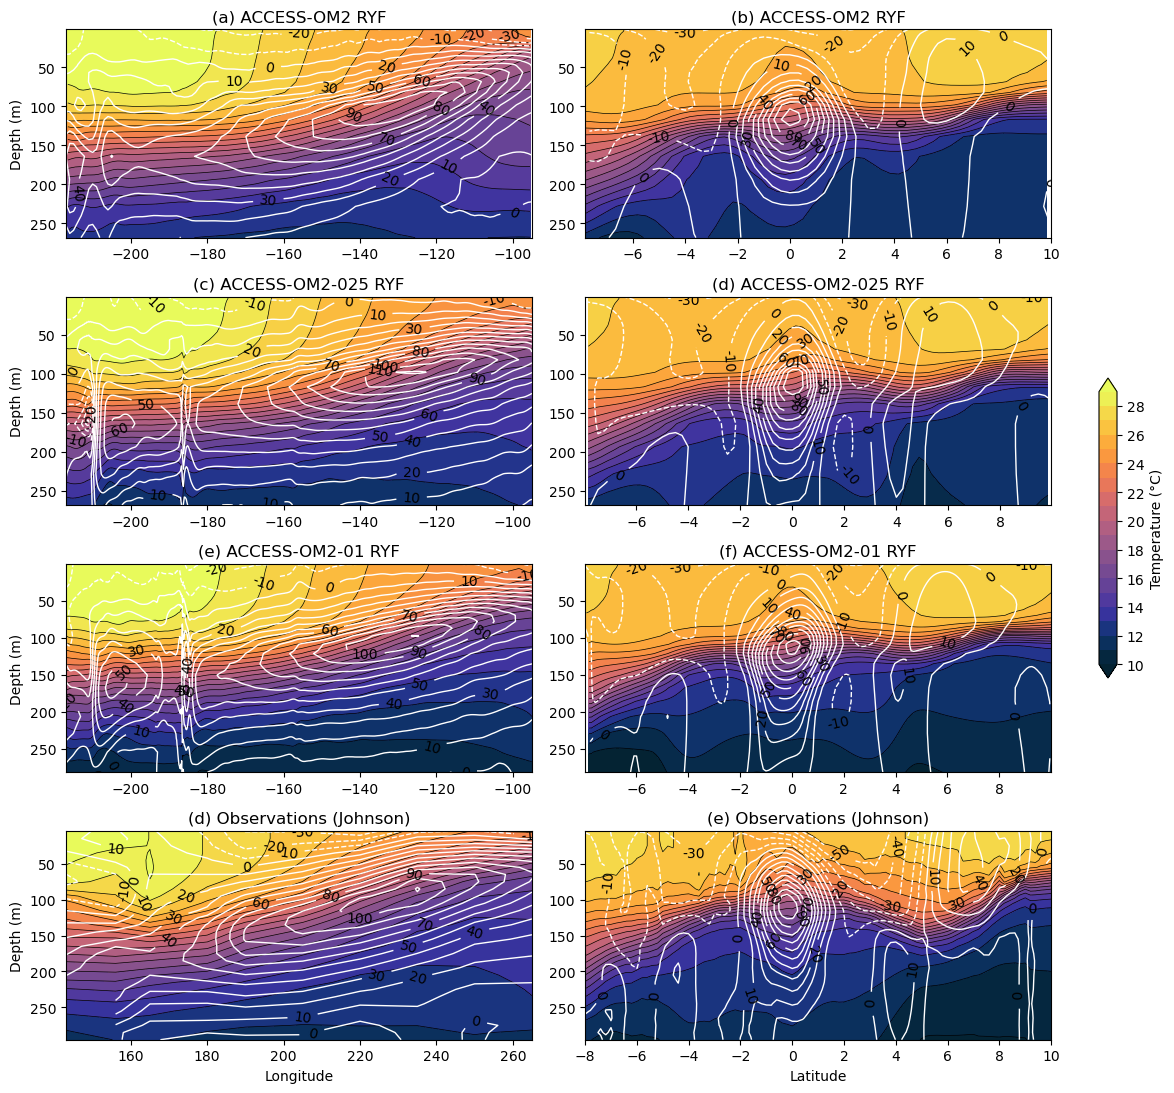

In [9]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ','(g) ','(h) ']

fig = plt.figure(figsize=(12,12))

# Select only a few runs for testing:
ekeys = ['1degRYF','025degRYF','01degRYF']

# Loop over experiments:
for i, ekey in enumerate(ekeys):
    
    # Load data:
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    # Plot equatorial slice:
    plt.subplot(4, 2, 2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False, linewidths=0.5)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean, upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq, colors='w', levels=clevelsU, linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + exptdict[ekey]['model'])
    
    # Plot latitude-depth slice:
    plt.subplot(4, 2, 2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean, upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w', levels=clevelsU, linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + exptdict[ekey]['model'])

# Plot observational equatorial slice:
plt.subplot(4, 2, 7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT, linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1, levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(4, 2, 8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
i=i+1
plt.title(labels[i] + 'Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92, 0.38, 0.015, 0.25])
cb = plt.colorbar(p1, cax=ax3, orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])

In [10]:
# Create a new WOA database:

db = 'woa13.db'
session_woa = cc.database.create_session(db)

NameError: name 'cc' is not defined

In [ ]:
directory_list=['/g/data/hh5/tmp/cosima/woa13/10',
                '/g/data/hh5/tmp/cosima/woa13/025',
                '/g/data/hh5/tmp/cosima/woa13/01',
                '/g/data/hh5/tmp/cosima/woa13/10_KDS50',
                '/g/data/hh5/tmp/cosima/woa13/10_KDS75',
                '/g/data/hh5/tmp/cosima/woa13/025_KDS50'
               ]

In [ ]:
# First copy the dictionary:
WOAlddict = exptdict.copy()

# Add on pre-interpolated WOA13 directories for every run
for ekey in WOAlddict.keys():
    e = WOAlddict[ekey]
    if (ekey.find('025deg') != -1):
        e['WOA13expt'] = '025_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom025.nc'
    elif (ekey.find('01deg') != -1):
        e['WOA13expt'] = '01'
        e['WOA13file'] = 'woa13_ts_??_mom01.nc'
    else:
        e['WOA13expt'] = '10_KDS50'
        e['WOA13file'] = 'woa13_ts_??_mom10.nc'

The approach here is slightly different to that used above - we will add the data directly to a dictionary which will also contain the observational data. This is done in the following code block:

In [ ]:
# Define list of experiments to load (useful for testing):
ekeys = ['1degRYF', '025degRYF', '01degRYF']

# Loop through models
for ekey in ekeys:
    e = WOAlddict[ekey]
    
    # Load temperature
    cat_subset = catalog[e['expt']]
    var_search = cat_subset.search(variable='temp')
    darray = var_search.to_dask()
    darray = darray['temp']
    darray = darray.sel(time=slice(e['itime'], e['ftime']))
    eq_temp = darray.sel(yt_ocean=0, method='nearest')
    
    # Set a text string to add the year range in title.
    e['yearrange'] = str(eq_temp.time.values[0])[0:7]+' to ' + str(eq_temp.time.values[-1])[0:7]
    print(ekey+': '+e['yearrange'])
    
    # Extract the WOA13 data
    cat_subset = catalog[e['WOA13expt']]
    var_search = cat_subset.search(variable='temp')
    darray = var_search.to_dask()
    darray = darray['temp']
    e['eq_temp_WOA13'] = darray.sel(GRID_Y_T=0., method='nearest').mean('time')
    
    # Calculate the bias
    eq_temp_anom = eq_temp.mean('time') - 273.15 - e['eq_temp_WOA13'].values
    eq_temp_anom.attrs['units'] = 'degrees Celsius'
    
    e['eq_temp_anom'] = eq_temp_anom.load()

Next we define a function that plots the bias for a given set of models

In [ ]:
# Plot Equatorial Slices:
def plot_eq(ekeys):
    
    # Define contour levels
    clev = np.arange(-3., 3.25, 0.25)

    # Loop through models
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        ax1 = plt.subplot(int(np.ceil(len(ekeys)/2)),2,i+1)
        
        # Plot bias as color
        pn = e['eq_temp_anom'].plot.contourf(cmap='bwr', levels=clev,
                                             add_colorbar=False, yincrease=False)
        
        # Plot WOA13 isotherms (and 20C bold)
        CS = e['eq_temp_WOA13'].plot.contour(levels=np.arange(0, 32, 2), colors='k')
        ax1.clabel(CS, inline=False, fmt='%d', fontsize=15)
        e['eq_temp_WOA13'].plot.contour(levels=[20.], colors='k', linewidths=3.)
        (e['eq_temp_anom']+e['eq_temp_WOA13'].values).plot.contour(levels=[20.], colors='k',
                                                                   linewidths=3., linestyles='--')
        
        # Add annotations
        plt.title('('+chr(i+ord('a'))+') ' + e['model'] + ', ' + e['yearrange'])
        ax1.set_ylim([300., 0.])
        ax1.set_xlim([-220., -80.])
        ax1.set_ylabel('Depth (m)')
        ax1.set_xlabel('Longitude ($^\circ$E)')
        if i==0:
            ax1.text(-210., 275., 'WOA13 Isotherms', fontsize=15)
            p0=pn;

    # Add colorbar
    ax5 = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(p0, cax=ax5, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')

Finally, actually plot some runs

In [ ]:
# Compare RYF simulations
fig = plt.figure(figsize=(14,12))
ekeys = ['1degRYF','025degRYF','01degRYF']
plot_eq(ekeys)

### Plot vertical profiles at the Equator compared to TAO, Johnson and WOA13 data

Here we plot vertical profiles of temperature and zonal velocity from the models and compare to the TAO, Johnson and WOA13 data sets.

The TAO data can be downloaded from https://www.pmel.noaa.gov/tao/drupal/disdel/ and for the locations listed below is sitting in `/g/data/ik11/observations/TAO` directory.

We start out by defining functions to extract profiles from a given longitude from WOA13, TAO and the Johnson data. 


In [ ]:
# TAO data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0, 400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0, 400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh, method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0, 400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh, method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    cat_subset = catalog['025_KDS50']
    var_search = cat_subset.search(variable='temp')
    darray = var_search.to_dask()
    darray = darray['temp']
    temp_WOA13_10 = darray.mean('time').sel(GRID_Y_T=0., method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA, method='nearest')
    
    return woa_temp_eq

Next we define a function to extract data from the models at a given longitude

In [ ]:
def find_Eqpt(ekey,lon):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='temp')
    darray = var_search.to_dask()
    darray = darray['temp']
    darray = darray.sel(time=slice(itime, ftime))
    temp = darray
    temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').mean('time').load() - 273.15
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='u')
    darray = var_search.to_dask()
    darray = darray['u']
    darray = darray.sel(time=slice(itime, ftime))
    u = darray
    u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').mean('time').load()*100
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

Next we define the different longitudes that we wish to plot (since each dataset uses a different type of longitude):

In [ ]:
# Define longitudes
lons = {'165e': {'mod': -195.,'tao': '165e','joh': 165.,'woa': -195.},
        '140w': {'mod': -140.,'tao': '140w','joh': 220.,'woa': -140.},
        '110w': {'mod': -110.,'tao': '110w','joh': 250.,'woa': -110.}
        }

Finally, lets plot some profiles

In [ ]:
f = plt.figure(figsize=(15,12),facecolor='white')

ekeys = ['1degRYF','025degRYF','01degRYF']
nln = len(lons)
tax = []
uax = []
for j, lkey in enumerate(lons.keys()):
         
    tax.append(plt.subplot(2,nln,j+1))
    uax.append(plt.subplot(2,nln,j+nln+1))

    # Loop through and plot models:
    for i, ekey in enumerate(ekeys):
        t_eq, u_eq = find_Eqpt(ekey, lons[lkey]['mod'])
        tax[j].plot(t_eq.values, -t_eq.st_ocean.values, label=exptdict[ekey]['model'], linewidth=2)
        uax[j].plot(u_eq.values, -u_eq.st_ocean.values, linewidth=2)

    # Extract observational data
    tao_temp, tao_u, tao_uc = get_TAO(lons[lkey]['tao'])
    joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
    woa_temp_eq = get_WOA(lons[lkey]['woa'])
    
    # Ploty observational temperatures
    tax[j].plot(tao_temp.mean('time'), -tao_temp.depth, '--', linewidth=2, label='TAO')
    tax[j].plot(joh_temp_eq, -dep_joh, '--', linewidth=2 ,label='Johnson et al')
    tax[j].plot(woa_temp_eq.values, -woa_temp_eq.ZT.values, '--', linewidth=2, label='WOA13')
    tax[j].set_xlabel('Temperature ($^\circ$C)')
    tax[j].set_ylabel('Depth (m)')
    tax[j].legend(loc=2)
    tax[j].set_ylim([-300., 0.])
    tax[j].set_xlim([8., 30.])
    tax[j].set_title(lons[lkey]['tao'] + ', 0N Temperature')
 
    # Plot observational zonal velocities (note, there is no U data from WOA13)
    uax[j].plot(tao_u.mean('time')*100., -tao_u.depth, '--', linewidth=2) # ADCP data
    # uax[j].plot(tao_uc.mean('time')*100., -tao_uc.depth, ':', linewidth=2) # Current meter data
    uax[j].plot(joh_u_eq*100.,-dep_joh,'--',linewidth=2)
    uax[j].set_xlabel('Zonal Velocity (ms$^{-1}$)')
    uax[j].set_ylabel('Depth (m)')
    uax[j].set_ylim([-300., 0.])
    uax[j].set_title(lons[lkey]['tao'] + ', 0N Zonal Velocity')

### Seasonal cycle of SST and zonal velocity along the Equator

Finally, we show an example of plotting a Hovemoeller plot of the seasonal cycle of temperature and zonal velocity against observations. This uses the `groupby` function to calculate a climatology for each variable.

First, define a function to extract the model data and take a climatology and the climatological anomaly

In [ ]:
depth = 0. # [m]
lats = (-5.,5.) # latitude range to average over [degrees]
lons = (-217,-95) # longitude range to plot [degrees]

def find_hov(ekey):

    expt = exptdict[ekey]['expt']
    n_files = exptdict[ekey]['n_files']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='temp')
    darray = var_search.to_dask()
    darray = darray['temp']
    darray = darray.sel(time=slice(itime, ftime))
    temp = darray
    temp_tot = temp.sel(st_ocean=depth,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).mean('yt_ocean')\
                        .sel(xt_ocean=slice(lons[0],lons[1])).load() - 273.15
    temp_tot.attrs['units'] = 'degrees Celsius'
    
    # Take climatology:
    temp_tot = temp_tot.groupby('time.month').mean('time')
    
    temp_anom = np.ma.anom(temp_tot,axis=0)
    
    # Extract velocity
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='u')
    darray = var_search.to_dask()
    darray = darray['u']
    darray = darray.sel(time=slice(itime, ftime))
    u = darray
    u_tot = u.sel(st_ocean=depth,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).mean('yu_ocean')\
                        .sel(xu_ocean=slice(lons[0],lons[1])).load()*100.
    u_tot.attrs['units'] = 'cms-1'
        
    # Take climatology:
    u_tot = u_tot.groupby('time.month').mean('time')
    
    u_anom = np.ma.anom(u_tot,axis=0)
    
    return temp_tot, temp_anom, u_tot, u_anom

Next, get the observations, first WOA13 temperature:

In [ ]:
cat_subset = catalog['025_KDS50']
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
temp_WOA13 = darray.sel(GRID_Y_T=slice(lats[0],lats[1])).mean('GRID_Y_T').sel(ZT=depth,method='nearest').sel(GRID_X_T=slice(lons[0],lons[1]))
temp_WOA13_anom = np.ma.anom(temp_WOA13,axis=0)

Next, zonal surface velocity from drifters. The drifter data set is taken from:

Laurindo, L., A. Mariano, and R. Lumpkin, 2017: An improved near-surface velocity climatology for the global ocean from drifter observations Deep-Sea Res. I, 124, pp.73-92, doi:10.1016/j.dsr.2017.04.009 .

And is currently in `/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc`

In [ ]:
obs_file = xr.open_dataset('/g/data/hh5/tmp/cosima/observations/original/drifter_monthlymeans.nc').rename({'Lat': 'latitude','Lon': 'longitude'})
obs_u = obs_file['U']

# latitude: 5S-5N, longitude: 45E-100E
obs_u_eq = obs_u.sel(latitude=slice(lats[0],lats[1])).sel(longitude=slice(lons[0],lons[1]))
m_obs_u_eq = obs_u_eq.mean('latitude')
a_obs_u_eq = np.ma.anom(m_obs_u_eq,axis=1)
new_a_obs_u_eq = np.transpose(a_obs_u_eq)

Finally, we plot the SST hovmoller and the zonal velocity hovmoeller

In [ ]:
# Plot SST hovmoeller against WOA13
Tmax = 3; Tmin = -Tmax; delT = 0.3
clevels = np.arange(Tmin,Tmax+delT,delT)

fig = plt.figure(figsize=(14,8))

ekeys = ['1degIAF','025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1,3,i+1)
    cax = plt.contourf(temp_tot.xt_ocean,temp_tot.month,temp_anom,levels=clevels,cmap=plt.cm.seismic )
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exptdict[ekey]['model'], fontsize=18)

ax = plt.subplot(1,3,3)
cax = ax.contourf(temp_WOA13.GRID_X_T,np.arange(12)+1,temp_WOA13_anom,levels=clevels,cmap=plt.cm.seismic )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14 )
ax.set_title('WOA13', fontsize=18)
cbar = plt.colorbar(cax)

fig.suptitle('SST seasonal cycle in Equatorial Pacific (degC)', fontsize=22);

In [ ]:
# Plot Zonal velocity hovmoeller:
Tmax = 100.; Tmin = -Tmax; delT = 0.1
clevels = np.arange(Tmin,Tmax+delT,delT)

fig = plt.figure(figsize=(14,8))

ekeys = ['1degIAF','025degIAF']

for i, ekey in enumerate(ekeys):
    temp_tot, temp_anom, u_tot, u_anom = find_hov(ekey)

    ax = plt.subplot(1,3,i+1)
    cax = plt.contourf(u_tot.xu_ocean,u_tot.month,u_anom,levels=clevels,cmap=plt.cm.seismic )
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Month', fontsize=14 )
    ax.set_title(exptdict[ekey]['model'], fontsize=18)

ax = plt.subplot(1,3,3)
cax = ax.contourf(obs_u_eq.longitude, np.arange(12)+1, new_a_obs_u_eq*100., levels=clevels, cmap=plt.cm.seismic )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Month', fontsize=14 )
cbar = plt.colorbar(cax)
ax.set_title('Drifter Observations', fontsize=18)

fig.suptitle('Zonal velocity seasonal cycle in Equatorial Pacific (cms-1)', fontsize=22);